# **Smart-UJ UAQUE**
Este Notebook hace parte del servicio inteligente "perfil grupal" y tiene como principal objetivo la generación de grupos a partir de las carácteristicas de los usuarios, incluyendo sus gustos y preferencias de lectura obtenidos a partir del historial de prestamos de material bibliográfico físico en la biblioteca Alfonso Borrero Cabal S.J.

Para formar estos grupos se realizarán varios acercamientos con diferentes técnicas, algóritmos y aproximaciones a partir de los modelos de recomendación clásicos. Posteriormente, se escogerá el mejor modelo para el sistema de recomendación y los grupos serán exportados al servicio inteligente "Servicio de recomedación UAQUE".

**Integrantes:**</br>
Johan Ortegón </br>
Juan Angarita </br>
Jorge Salgado </br>
Daniel Tibaquira </br></br>
**Directora de Proyecto de Grado:** </br>
Viky Arias </br>


#Importación de datos

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

Se realizará la agrupación por Dewey inicialmente

La columna count nos señala cuantas veces se ha prestado el libro, esto a partir del dataset de prestamos y no el de material. Esto debido a que nos importa solo contar el número de prestamos en una franja de tiempo especifico. 


In [17]:
df = pd.read_json('../data/TABLA_JOIN.json')
df.columns

Index(['RowID', 'Mes', 'Fecha', 'IDItem', 'NumeroUbicacion', 'Dewey',
       'Ubicacion', 'TipoItem_x', 'Llave_x', 'Perfil', 'Programa', 'Facultad',
       'IDUsario', 'Year', 'Signatura', 'UbicacionActual', 'TipoItem_y',
       'TotalPrestamos', 'Llave_y', 'Copias', 'Autor', 'Titulo', 'Tema650',
       'AnioPublicación', 'NO_DEWEY', 'ENCABEZAMIENTO', 'original', 'Temas',
       'union'],
      dtype='object')

In [11]:
##Importar tabla
pesos_usuarios_pre = pd.read_json('../data/pesos_usuarios_no_cluster_244k.json')

In [12]:
display(pesos_usuarios_pre)

,Dewey,Llaves,ID de usuario ok,Peso del prestamos
1809,0,836405,0f655061dc0b588e221cd03bd3e7dfa056518ec3,13.000
2040,0,864918,95ae56fe5202b6a674123079b854aedee57f33d8,9.000
2747,0,918693,fed86974c1b264f8d7b6e36200c7ad5ca8ef5a90,6.250
2733,0,918693,0c6753cb0638b5141332010b8e670fbf7c82074b,6.000
422,0,355238,53f6e0708e3ac4f0687c78f76906f682242e1687,5.000
...,...,...,...,...
242993,Video,910655,6345baa824b642a2e5c752adaec9ff00786a7f75,0.125
241607,Video,752654,822efdea0e535fb37ccef60dc9e9ad82e8ee7e1c,0.125
242991,Video,910655,51fb8bc6df2f4f80beeafdfaf8bf0d2f8a05342e,0.125
242990,Video,910655,395733bdb8272fe03098bd8a9a28b9d2a08f32d1,0.125


In [23]:
df["peso_año"] = df.apply(lambda row: 1/2**(2021-row.Year), axis=1 )

In [25]:
gruposDewey = df.groupby(["Dewey","Llave_x"], group_keys=False)["peso_año"].sum().reset_index(name="Peso") #.reset_index(name='count').sort_values(['count'], ascending=False)
g_libros = gruposDewey.groupby('Dewey', group_keys=False)
top_libros = g_libros.apply(lambda x: x.sort_values(by='Peso',ascending=False))
display(top_libros)

,Dewey,Llave_x,Peso
861,0,883107,49.000
623,0,801979,41.625
977,0,918693,20.750
785,0,863079,15.750
707,0,836405,14.000
...,...,...,...
100245,Video,767575,0.125
99884,Video,720828,0.125
100238,Video,767383,0.125
100236,Video,767317,0.125


In [26]:
top_usuarios = pesos_usuarios_pre.copy()

In [29]:
def recommend(user='0cb3e9156de3ee3c8c5ddc21f48516bfc1ca9ef5', n=10):
  
    #buscar los deweys donde esta el usuario
    grupos_usuario = top_usuarios.loc[top_usuarios["ID de usuario ok"]==user]
    #display(grupos_usuario)
    deweys = grupos_usuario[["Dewey","Peso del prestamos"]]
    grupos_libros = top_libros.groupby(["Dewey"])

    #deweys_vals = deweys.values
    #display(deweys_vals)
    termino_abajo = deweys["Peso del prestamos"].sum()
    #print(termino_abajo)
    deweys = deweys.groupby("Dewey")["Peso del prestamos"].sum().reset_index(name="Peso")
    #unique, counts = np.unique(deweys_vals, return_counts=True)
    #display( deweys)
    return deweys
    recomendaciones_df = pd.DataFrame(columns=['Título', 'Dewey'])

    #traer el libro mas recomendado de ese Dewey
    i = 0
    for dewey in deweys["Dewey"]:
        print(grupos_libros.get_group(dewey))

        #calculamos Ri
        #print(np.asarray((unique, counts))[1][i])
        Ri = round(n * deweys.loc[i].Peso / termino_abajo)
        #print(Ri)
        llaves = grupos_libros.get_group(dewey).iloc[0:Ri]["Llaves"]
        #print(llaves)
        for llave in llaves:
            titulo = df.loc[df["Llaves"]==llave]
            recomendaciones_df.loc[len(recomendaciones_df)] = [titulo.iloc[0]["Título"] , dewey]
        i = i+1
    #print(deweys)
    #display(recomendaciones_df)
    #TODO: revisar si el usuario ya lo presto

In [30]:
# pesos_usuarios = pesos_usuarios_pre.copy()
# pesos_usuarios = pd.DataFrame(columns= df["Dewey"].unique(),dtype=float)
# tam = len(df["Dewey"].unique())
# pesos_usuarios.columns = pesos_usuarios.columns.astype(str)
# print(tam)
# display(pesos_usuarios)

# ids = df["IDUsario"].unique()
# i = 0
# for usuario in ids:
#     pesos_usuarios.loc[i] =  np.zeros((tam,), dtype=int)
#     #Para cada usuario traer sus Deweys y sus pesas asociados
#     result_user = recommend(user=usuario, n=13)
#     # Recorrer los Deweys y Pesos para plasmarlos en una matriz
#     for index, row  in result_user.iterrows():
#         d = row["Dewey"]
#         p = row["Peso"]
#         pesos_usuarios[d][i] = p
#     i = i+1

display(pesos_usuarios)

110


,720,540,510,710,740,810,820,330,860,690,...,50,90,30,GRABACIÓN SONORA,TESIS,VIDEO,PARTITURA,REVISTA,MAPA,990


,720,540,510,710,740,810,820,330,860,690,...,50,90,30,GRABACIÓN SONORA,TESIS,VIDEO,PARTITURA,REVISTA,MAPA,990
0,2.625,0.0,0.000,0.250,0.25,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.500,1.0,1.250,0.000,0.00,0.5,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.0,0.000,3.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.250,0.0,0.000,0.000,0.25,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.500,0.0,0.000,0.875,1.00,0.0,0.0,0.0,0.0,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25230,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25231,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25232,0.000,0.0,0.125,0.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25233,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
pesos_usuarios.to_json('../data/pesos_usuarios_deweys')

# Configuración Modelos
A partir del archivo "Comparación modelos" se puede concluir que el modelo que ayuda en mayor medida a agrupar los datos, minimizando el número de clusters con tamaño menor a 20 y la desviación estandar es kmeans con los siguiente parámetros:
* Filas normalizadas = true
* Columnas normalizadas = true
* PCA = 0.95
* Número de clusters = 150
* Número de iteraciones = 500

In [36]:
resumen = pd.DataFrame(columns = ["Tecnica","PCA", "Norm_filas", "Norm_col", "Precision", "Desviacion_estandar", "Media", "Coeficiente_variacion", "Clusters","Grupo_mas_grande", "Grupos<10", "Grupos<20"])


In [37]:
def std_dev_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.std(sizes_labels)

In [38]:
def mean_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.mean(sizes_labels)

In [39]:
#
PCANO = 0.95
num_clusters = 150
num_iter = 20

# Algoritmo kmeans

silhouette_score:  0.3890167595208205


<AxesSubplot:>

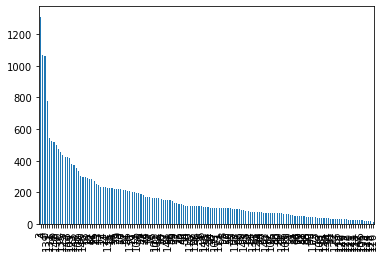

In [40]:
##Exportamos los datos del modelo que nos dio mejores resultados
#Normalización
from sklearn.decomposition import PCA

sumatoria = pesos_usuarios.sum(axis=1)
pesos_norm = pesos_usuarios.div(sumatoria, axis=0).fillna(0)

scaler = MinMaxScaler()
pesos_norm = scaler.fit_transform(pesos_norm.values)

#PCA
# pca = PCA().fit(pesos_norm)

# pca = PCA(n_components=0.95)
# pesos_pca = pca.fit_transform(pesos_norm)

#print("Número de componentes: ",pca.n_components_)
  #Kmeans
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = num_iter)
k_means.fit_predict(pesos_norm)
centroids = k_means.cluster_centers_
labels = k_means.labels_

  #Desempeño
pres = silhouette_score(pesos_norm, labels)
print("silhouette_score: ", pres)

  #copiamos el dataframe y agregamos los clusters para gráficar la distribución
df2 = pesos_usuarios.copy()
df2["cluster"] = labels
df2.groupby("cluster")["cluster"].count()
display(df2["cluster"].value_counts().plot(kind='bar'))

  #Cálculo de métricas
media = mean_cluster(df2,labels)
desviacion = std_dev_cluster(df2,labels)
data = df2.groupby('cluster')['720'].count()
peque10 = len(data[data<=10])
peque20 = len(data[data<=20])
masGrande = data.max()
#Agregamos los datos a nuestra tabla de resumen para comparar
resumen = resumen.append({'Tecnica':"K-MEANS",
                              'PCA':0.95,
                              'Norm_filas':True,
                              'Norm_col':True,
                              'Precision':pres,
                              'Desviacion_estandar':desviacion,
                              'Media':media,
                              'Coeficiente_variacion':desviacion/media, 
                              'Clusters': num_clusters,
                              "Grupos<20":peque20,
                              "Grupos<10":peque10 , 
                              "Grupo_mas_grande":masGrande}, ignore_index=True)

# Exportación del modelo
Asignaremos nuevamente a todo registro su respectivo id de usuario.
Exportamos a los usuarios con su respectivo cluster en el archivos "grupos.json "

In [44]:
dfp = df2.loc[df2['cluster'] == 12]
dfp.loc[dfp['510'] > 0]

,720,540,510,710,740,810,820,330,860,690,...,90,30,GRABACIÓN SONORA,TESIS,VIDEO,PARTITURA,REVISTA,MAPA,990,cluster
3745,0.00,0.0,0.500,0.0,0.00,0.000,0.00,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12
5794,0.00,0.0,0.250,0.0,2.75,0.125,0.25,3.375,0.000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12
6646,0.00,0.0,0.375,0.0,0.00,0.000,0.00,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12
9151,0.00,0.0,0.250,0.0,0.00,0.000,0.00,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12
9264,0.00,0.0,0.500,0.0,0.00,0.000,0.00,0.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12
9286,0.50,0.0,0.500,0.0,0.00,0.500,0.00,0.000,0.500,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12
9299,0.00,0.0,0.125,0.0,0.00,0.000,0.25,0.000,0.375,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12
9785,1.00,0.0,0.500,0.0,0.00,0.000,0.75,1.000,2.500,0.5,...,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,12
12384,0.50,0.0,0.500,0.0,0.00,0.000,0.00,0.250,0.000,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12
15833,0.25,0.0,0.625,0.0,0.00,0.625,1.50,0.000,0.375,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,12


In [45]:
df2

,720,540,510,710,740,810,820,330,860,690,...,90,30,GRABACIÓN SONORA,TESIS,VIDEO,PARTITURA,REVISTA,MAPA,990,cluster
0,2.625,0.0,0.000,0.250,0.25,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67
1,0.500,1.0,1.250,0.000,0.00,0.5,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60
2,0.000,0.0,0.000,3.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
3,0.250,0.0,0.000,0.000,0.25,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100
4,11.500,0.0,0.000,0.875,1.00,0.0,0.0,0.0,0.0,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25230,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125
25231,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
25232,0.000,0.0,0.125,0.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
25233,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123


In [49]:
ids = df["IDUsario"].unique()
df2["ids usuarios"] = ids

In [51]:
len(df["IDUsario"].unique())

25235

In [52]:
len(df2["ids usuarios"].unique())

25235

In [53]:
df2.loc[df2['ids usuarios'] == '11d403e3de4f03317411ba85207601ba616fbd49']

,720,540,510,710,740,810,820,330,860,690,...,30,GRABACIÓN SONORA,TESIS,VIDEO,PARTITURA,REVISTA,MAPA,990,cluster,ids usuarios
328,0.0,0.0,0.0,0.0,1.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,11d403e3de4f03317411ba85207601ba616fbd49


In [54]:
df2.to_json('../data/Cluster_deweys.json')

In [ ]:
#datasetPrestamos = pd.read_json('/content/drive/MyDrive/UAQUE/Grupos.json')

In [ ]:
#datasetPrestamos.head()

In [ ]:
#len(datasetPrestamos.loc[datasetPrestamos['cluster'] == 69])